# Image Classification Week 1 - Bag of Visual Words
### Team 8: Carlos Boned, Luis González, Sígrid Vila

### Table of contents:
    1. Definition of functions and classes
    2. Tests and hyperparameter optimization
    3. Visualizations
    4. Conclusions

### 1. Definition of functions and classes
First we import the libraries that we're going to use in the notebook.

In [1]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import os, tqdm
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from collections import Counter
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler

from skimage.feature import fisher_vector, learn_gmm

from typing import *

import wandb
os.environ["WANDB_ENTITY"] = "c3-mcv"
wandb.login(key = '14a56ed86de5bf43e377d95d05458ca8f15f5017', relogin=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Luis/.netrc


True

We define some utils functions needed in the following cells.

In [2]:
def read_pickle(filepath:str) -> Any:
    """
    Read and deserialize a pickled object from the specified file.

    Parameters:
        filepath (str): The path to the file containing the pickled object.

    Returns:
        Any: The deserialized object from the pickled file.
    """
    with open(filepath, "rb") as file:
        load_file = pickle.load(file)

    return load_file

def write_pickle(information:Any,filepath:str):
    """
    Serialize and write an object to the specified file using pickle.

    Parameters:
        information (Any): The object to be serialized and written.
        filepath (str): The path to the file to write the pickled object.
    """

    abs_path = os.path.dirname(filepath)
    os.makedirs(abs_path, exist_ok=True)
    with open(filepath, "wb") as f:
        pickle.dump(information, f)

def split_image_into_blocks(image, level):
    """
    Splits an input image into blocks at a level of granularity.

    Parameters:
        image: numpy array representing the input image.
        level: an integer specifying the level of granularity to split the image.

    Returns:
        A list containing blocks of the input image, where each block corresponds to a region
        obtained by recursively dividing the image into 2^level sub-blocks along both axes.
    """
    
    # Initialize the list to store blocks
    blocks = []
    # Process each level
    for l in range(1, level + 1):
        # Calculate the number of splits along each axis
        splits = 2 ** (l - 1)

        # Split the image into blocks using np.array_split along both axes
        row_blocks = np.array_split(image, splits, axis=0)
        for row_block in row_blocks:
            col_blocks = np.array_split(row_block, splits, axis=1)
            for col_block in col_blocks:
                blocks.append(col_block)

    return blocks 

def histogram_intersection_kernel(X, Y):
    """
    Histogram intersection kernel.
    
    Parameters:
        X: array-like of shape (n_samples_X, n_features)
        Y: array-like of shape (n_samples_Y, n_features)
    
    Returns:
        kernel_matrix: array of shape (n_samples_X, n_samples_Y)
    """
    # Expand dimensions of X and Y for broadcasting
    X_expanded = np.expand_dims(X, 1)
    Y_expanded = np.expand_dims(Y, 0)

    # Compute the minimum between each pair of vectors (broadcasting)
    minima = np.minimum(X_expanded, Y_expanded)

    # Sum over the feature dimension to compute the kernel
    kernel_matrix = np.sum(minima, axis=2)

    return kernel_matrix

def histogram_intersection_distance(X, Y):
    """
    Histogram intersection distance for kNN.
    
    Parameters:
        X: array-like of shape (n_samples_X, n_features)
        Y: array-like of shape (n_samples_Y, n_features)
    
    Returns:
        distance_matrix: array of shape (n_samples_X, n_samples_Y)
    """
    # Calculate the histogram intersection similarity
    similarity = histogram_intersection_kernel(X, Y)
    
    max_similarity = np.minimum(X.sum(axis=1)[:, np.newaxis], Y.sum(axis=1)[np.newaxis, :])
    return 1 - (similarity / max_similarity)

def accuracy(predictions, labels):
    """
    Calculates the accuracy of a set of predictions compared to the actual labels.

    Parameters:
        predictions: numpy array containing the predicted values.
        labels: numpy array containing the actual labels.

    Returns:
        A float representing the accuracy.
    """
    return sum(predictions == labels) / len(labels)

def precision(predictions, labels, class_label):
    """
    Calculates precision for a specific class in a classification task.

    Parameters:
        predictions: numpy array containing the predicted class labels.
        labels: numpy array containing the actual class labels.
        class_label: the specific class for which precision is calculated.

    Returns:
        Precision value for the specified class.
    """
    tp = np.sum((predictions == class_label) & (labels == class_label))
    fp = np.sum((predictions == class_label) & (labels != class_label))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall(predictions, labels, class_label):
    """
    Calculates recall for a specific class in a classification task.

    Parameters:
        predictions: numpy array containing the predicted class labels.
        labels: numpy array containing the actual class labels.
        class_label: the specific class for which recall is calculated.

    Returns:
        Recall value for the specified class.
    """
    tp = np.sum((predictions == class_label) & (labels == class_label))
    fn = np.sum((predictions != class_label) & (labels == class_label))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def average_precision(predictions, labels):
    """
    Calculates the average precision across all classes in a classification task.

    Parameters:
        predictions: numpy array containing the predicted class labels.
        labels: numpy array containing the actual class labels.

    Returns:
        The average precision across all classes.
    """
    classes = np.unique(labels)
    return np.mean([precision(predictions, labels, c) for c in classes])

def average_recall(predictions, labels):
    """
    Calculates the average recall across all classes in a classification task.

    Parameters:
        predictions: numpy array containing the predicted class labels.
        labels: numpy array containing the actual class labels.

    Returns:
        The average recall across all classes.
    """
    classes = np.unique(labels)
    return np.mean([recall(predictions, labels, c) for c in classes])

def average_f1(predictions, labels):
    """
    Calculates the average F1 score across all classes in a classification task.

    Parameters:
        predictions: numpy array containing the predicted class labels.
        labels: numpy array containing the actual class labels.

    Returns:
        The average F1 score across all classes.
    """
    
    return 2 * average_precision(predictions, labels) * average_recall(predictions, labels) / (average_precision(predictions, labels) + average_recall(predictions, labels))

def compute_macro_roc_curve(y_onehot_test, y_score):
    """
    Computes the ROC curve and ROC area for each class.
    
    Parameters:
        y_onehot_test: array-like of shape (n_samples, n_classes)
        prob_matrix: array-like of shape (n_samples, n_classes)
    
    Returns:
        fpr_grid: Array of false positive rates at which ROC curves are evaluated.
        mean_tpr: Array of mean true positive rates corresponding to the fpr_grid.
    """
    n_classes = y_onehot_test.shape[1]
    # store the fpr, tpr
    fpr, tpr = dict(), dict()
    fpr_grid = np.linspace(0.0, 1.0, 1000)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    return fpr_grid, mean_tpr / n_classes

def compute_micro_roc_curve(y_onehot_test, y_score):
    """
    Computes the micro ROC curve and ROC area.
    
    Parameters:
        y_onehot_test: array-like of shape (n_samples, n_classes)
        prob_matrix: array-like of shape (n_samples, n_classes)
        
    Returns:
        fpr: Array of false positive rates.
        tpr: Array of true positive rates.
    """
    # Compute micro-average ROC curve
    fpr, tpr, _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())

    return fpr, tpr



Now we define the class that englobes all the Bag of Visual Words system. It can perform all the tests proposed in this lab, so we decided to code it as a class to make it more space efficient and easy for us to execute all tests. Moreover, we perfrom the hyperparameter optimization using wandb.ai.

In [66]:
class BoVW():
    def __init__(self, config, size_per_class=1e9, preload_features=False, folder_path_train='./MIT_split/train', folder_path_test='./MIT_split/test'):
        """
        Bag-of-Visual-Words (BoVW) image classifier.

        Parameters:
        - config: Dictionary containing configuration parameters for the BoVW model.
        - size_per_class: Maximum number of images per class to use for training.
        - preload_features: If True, preloads computed features from saved files.
        - folder_path_train: Path to the training dataset folder.
        - folder_path_test: Path to the testing dataset folder.
        """
        self.config = config
        
        self.train_dataset = {'image_paths': [], 'labels': []}
        self.test_dataset = {'image_paths': [], 'labels': []}

        # Read train images, saving the path and the label
        for label in os.listdir(folder_path_train):
            for i,image_name in enumerate(os.listdir(os.path.join(folder_path_train, label))):
                self.train_dataset['image_paths'].append(os.path.join(folder_path_train, label, image_name))
                self.train_dataset['labels'].append(label)

                # good for making a small test
                if i >= size_per_class:
                    break
        
        # Read test images, saving the path and the label        
        for label in os.listdir(folder_path_test):
            for i,image_name in enumerate(os.listdir(os.path.join(folder_path_test, label))):
                self.test_dataset['image_paths'].append(os.path.join(folder_path_test, label, image_name))
                self.test_dataset['labels'].append(label)
                
                # good for making a small test
                if i >= size_per_class:
                    break
        
        self.train_dataset['labels'] = np.array(self.train_dataset['labels'])
        self.test_dataset['labels'] = np.array(self.test_dataset['labels'])
        
        # Computation of the train and test features
        self.train_features_cluster, self.train_features_level, self.test_features_level = self._compute_features(preload=preload_features)
        
        # Classification
        if self.config['classifier'] == 'knn':
            self.classifier = KNeighborsClassifier(n_neighbors=self.config['n_neigh'], n_jobs=-1, metric=self.config['metric'])
        elif self.config['classifier'] == 'svm':
            self.classifier = SVC(kernel = self.config['kernel'], degree=self.config['degree_pol'], class_weight = 'balanced', gamma = 'auto', C = self.config['C'], probability=True, random_state=123)
        elif self.config['classifier'] == 'logistic':
            self.classifier = LogisticRegression(multi_class = 'auto', penalty='l2', max_iter=300, solver='lbfgs', C = self.config['C'], class_weight = 'balanced', n_jobs=-1, random_state=123)
        
        # Dimensionality reduction
        self.dim_red = None
        if self.config['n_components'] > 0:
            self.dim_red = PCA(n_components = self.config['n_components'])

        # Standarization
        self.scaler = None
        if self.config['scaler']:
            self.scaler = StandardScaler(with_mean=True, with_std=True)


            
    def _compute_descriptor_level(self, gray_chunk, color_chunk):
        """
        Computes descriptors for a given image chunk at a specified level of granularity.

        Parameters:
            gray_chunk: Grayscale image chunk.
            color_chunk: Color image chunk.

        Returns:
            Descriptors computed for the input image chunk.
        """
        
        if self.config['descriptor'] == 'dense_sift':
            # Initialize Dense SIFT extractor
            sift = cv2.SIFT_create()
            kp = [cv2.KeyPoint(x, y, self.config['step_size']) for y in range(0, gray_chunk.shape[0], self.config['step_size'])
                                                                for x in range(0, gray_chunk.shape[1], self.config['step_size'])]
            _, des = sift.compute(gray_chunk, kp)

        elif self.config['descriptor'] == 'sift':
            # Initialize Dense SIFT extractor
            sift = cv2.SIFT_create(nfeatures=self.config["n_features"])
            _, des = sift.detectAndCompute(gray_chunk, None)

        elif self.config['descriptor'] == 'akaze':
            # Initialize AKAZE extractor
            akaze = cv2.AKAZE_create(descriptor_type=cv2.AKAZE_DESCRIPTOR_KAZE, threshold=0.0001)
            _, des = akaze.detectAndCompute(color_chunk, None)
          
        return des
    
    

    def _compute_features(self, preload=False):
        """
        Computes and stores image features for training and testing datasets.

        Parameters:
            preload: If True, preloads computed features from saved files.

        Returns:
            Tuple containing cluster features for training, descriptor features for training, and descriptor features for testing.
        """
        
        if preload:
            level_features_train = read_pickle(filepath=os.path.join(".", "descriptors", "train", self.config["descriptor"]+'_'+ str(self.config["level_pyramid"]) + ".pkl"))
            level_features_test = read_pickle(filepath=os.path.join(".", "descriptors", "test", self.config["descriptor"]+'_'+ str(self.config["level_pyramid"]) + ".pkl"))
            cluster_features_train = np.concatenate([np.concatenate(image_feat_array, axis=0) for image_feat_array in level_features_train], axis=0)
            return cluster_features_train, level_features_train, level_features_test

        cluster_features_train = []
        level_features_train, level_features_test = [], []
        
        # Iterate over all files in the directory
        for i,dataset in enumerate([self.train_dataset['image_paths'], self.test_dataset['image_paths']]):
            for filename in tqdm.tqdm(dataset, desc='Extracting features from dataset %d' % i):
                
                # Load the imag
                img = cv2.imread(filename)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img_blocks = split_image_into_blocks(img, self.config['level_pyramid'])
                gray_blocks = split_image_into_blocks(gray, self.config['level_pyramid'])

                level_features = [] # levels x np.array([n_features, 128])
                for c_block, g_block in zip(img_blocks, gray_blocks):
                    des = self._compute_descriptor_level(g_block, c_block)

                    if des is not None:
                        level_features.append(des.astype(np.float64)) # may contain different number of features for each level
                    else:
                        hist, _ = np.histogramdd(c_block.reshape(-1, 3), bins = 128 if self.config['descriptor'] != 'akaze' else 64)
                        level_features.append((hist.sum(axis=1).sum(axis=0) / hist.sum()).reshape(1,-1).astype(np.float64))
                
                cluster_features = np.concatenate(level_features, axis=0) # shape (levels * n_features, 128), n_features does not need to be the same for each level

                if i == 0:
                    cluster_features_train.append(cluster_features)
                    level_features_train.append(level_features)
                else:
                    level_features_test.append(level_features)

        # saving features -> from level_features we can get the cluster_features
        os.makedirs(os.path.join(".", "descriptors", "train"), exist_ok=True)
        write_pickle(filepath=os.path.join(".", "descriptors", "train", self.config["descriptor"]+'_'+ str(self.config["level_pyramid"]) + ".pkl"), information=level_features_train)
        
        os.makedirs(os.path.join(".", "descriptors", "test"), exist_ok=True)
        write_pickle(filepath=os.path.join(".", "descriptors", "test", self.config["descriptor"]+'_'+ str(self.config["level_pyramid"]) + ".pkl"), information=level_features_test)
        return np.concatenate(cluster_features_train, axis=0), level_features_train, level_features_test

    
    
    def fit(self, train_features_cluster=None, train_features_level=None, y_train_labels=None):
        """
        Fit the Bag of Visual Words (BoVW) model using training data.

        Parameters:
            train_features_cluster: Aggregated features for visual word creation.
            train_features_level: Detailed features at different scales within each image.
            y_train_labels: Labels for the training data.

        """
        
        if train_features_cluster is None and train_features_level is None and y_train_labels is None:
            train_features_cluster = self.train_features_cluster
            train_features_level = self.train_features_level
            y_train_labels = self.train_dataset['labels']
            
        # Clustering for the visual words
        if self.config["fisher"]:
            self.cluster = learn_gmm(self.train_features_cluster, n_modes=self.config["n_words"], gm_args={'n_init': 1, 'max_iter': 50, 'covariance_type':'diag'})
        else:
            self.cluster = MiniBatchKMeans(n_clusters=self.config['n_words'], n_init='auto', compute_labels=False, random_state=123)
            self.cluster.fit(self.train_features_cluster)
        
        # Calculate the visual words for each image and level
        dim_des = 128 if self.config['descriptor'] != 'akaze' else 64
        dim_size = self.config['n_words'] if not self.config["fisher"] else 2*self.config['n_words']*dim_des + self.config['n_words'] # n_words or 2KD+K for fisher
        visual_words_train = np.zeros((len(train_features_level), self.config['level_pyramid'], dim_size), dtype=np.float64) # we will need shape (n_images, dim_size)
        
        for i in range(len(train_features_level)):
            for l in range(self.config['level_pyramid']):
                words = self.cluster.predict(train_features_level[i][l]) if not self.config["fisher"] else fisher_vector(train_features_level[i][l], self.cluster)
                visual_words_train[i,l,:] = np.bincount(words, minlength=self.config['n_words']) if not self.config["fisher"] else words

        visual_words_train = visual_words_train.reshape(len(train_features_level), -1) #get shape (n_images, dim_size)

        # Standarization
        if self.config['scaler']:
            visual_words_train = self.scaler.fit_transform(visual_words_train)

        # Dimensionality reduction
        if self.dim_red is not None:
            visual_words_train = self.dim_red.fit_transform(visual_words_train)
        
        # Compute distance/kenrel matrix
        if self.config['classifier'] == 'knn' and self.config['metric'] == 'precomputed':
            self.visual_words_train_old = visual_words_train.copy()
            visual_words_train = histogram_intersection_distance(visual_words_train, visual_words_train)
        elif self.config['classifier'] == 'svm' and self.config['kernel'] == 'precomputed':
            self.visual_words_train_old = visual_words_train.copy()
            visual_words_train = histogram_intersection_kernel(visual_words_train, visual_words_train)
            
        # Fit the classifier
        self.classifier.fit(visual_words_train, y_train_labels)


    def predict(self, test_features_level=None):
        """
        Predict labels for test data using the trained BoVW model.

        Parameters:
            test_features_level (array-like, optional): Detailed features at different scales within each test image. Defaults to None.

        Returns:
            tuple: Predicted labels and class probabilities.
        """

        if test_features_level is None:
            test_features_level = self.test_features_level

        dim_des = 128 if self.config['descriptor'] != 'akaze' else 64
        dim_size = self.config['n_words'] if not self.config["fisher"] else 2*self.config['n_words']*dim_des + self.config['n_words'] # n_words or 2KD+K for fisher
        visual_words_test = np.zeros((len(test_features_level), self.config['level_pyramid'], dim_size), dtype=np.float64) # we will need shape (n_images, dim_size)

        # Calculate visual words for tet set
        for i in range(len(test_features_level)):
            for l in range(self.config['level_pyramid']):
                words = self.cluster.predict(test_features_level[i][l]) if not self.config["fisher"] else fisher_vector(test_features_level[i][l], self.cluster)
                visual_words_test[i,l,:] = np.bincount(words, minlength=self.config['n_words']) if not self.config["fisher"] else words

        visual_words_test = visual_words_test.reshape(len(test_features_level), -1) # get shape (n_images, dim_size*level_pyramid)

        # Standarization
        if self.config['scaler']:
            visual_words_test = self.scaler.transform(visual_words_test)
        
        # Dimensionality reduction
        if self.dim_red is not None:
            visual_words_test = self.dim_red.transform(visual_words_test)

        # Compute distance/kenrel matrix
        if self.config['classifier'] == 'knn' and self.config['metric'] == 'precomputed':
            visual_words_test = histogram_intersection_distance(visual_words_test, self.visual_words_train_old)
        elif self.config['classifier'] == 'svm' and self.config['kernel'] == 'precomputed':
            visual_words_test = histogram_intersection_kernel(visual_words_test, self.visual_words_train_old)

        # Predict labels and class probabilities
        return self.classifier.predict(visual_words_test), self.classifier.predict_proba(visual_words_test)

    
def cross_validation(bovw):
    """
    Perform cross-validation using the given BoVW model.

    Parameters:
        bovw (BoVW): Bag of Visual Words model.

    Returns:
        tuple: Predictions, class probabilities, and true labels for each cross-validation fold.
    """
    
    kf = KFold(n_splits=bovw.config['n_folds'], shuffle=True, random_state=123)
    predictions, y_scores, labels = [], [], []

    for train_index, test_index in tqdm.tqdm(kf.split(bovw.train_features_level), desc='Cross validation', total=bovw.config['n_folds']):
        # Split features and labels for this fold
        X_train_level, X_test_level = [bovw.train_features_level[i] for i in train_index] , [bovw.train_features_level[i] for i in test_index]
        y_train_level, y_test = bovw.train_dataset['labels'][train_index], bovw.train_dataset['labels'][test_index]

        X_train_cluster = np.concatenate([np.concatenate(image_feat_array, axis=0) for image_feat_array in X_train_level], axis=0)

        # Fit the classifier
        bovw.fit(X_train_cluster, X_train_level, y_train_level)
        # Predict the test set
        pred, y_score = bovw.predict(X_test_level)
        
        y_scores.append(y_score)
        predictions.append(pred)
        labels.append(y_test)

    return predictions, y_scores, labels
    
def log_metrics(config, predictions, y_scores, y_test, plot='micro'):
    """
    Logs various evaluation metrics and ROC curve data to WandB.

    Parameters:
        config (dict): Configuration parameters for the model.
        predictions (list): List of predicted labels for each fold in cross-validation.
        y_scores (list): List of predicted probabilities for each fold in cross-validation.
        y_test (list): List of true labels for each fold in cross-validation.
        plot (str, optional): Type of ROC curve to plot ('micro' or 'macro'). Defaults to 'micro'.
    """
    
    wandb.log({
        'accuracy': np.mean([accuracy(predictions[i], y_test[i]) for i in range(len(predictions))]),
        'average_precision': np.mean([average_precision(predictions[i], y_test[i]) for i in range(len(predictions))]),
        'average_recall': np.mean([average_recall(predictions[i], y_test[i]) for i in range(len(predictions))]),
        'average_f1': np.mean([average_f1(predictions[i], y_test[i]) for i in range(len(predictions))]),
    })

    # ----------------- #
    #Log ROC curve
    
    n_folds = config['n_folds']
    result_auc = []
    for n in range(n_folds):
        y_onehot_test = LabelBinarizer().fit_transform(y_test[n])
        if plot == 'micro':
            fpr, tpr = compute_micro_roc_curve(y_onehot_test, y_scores[n])
        else:
            fpr, tpr = compute_macro_roc_curve(y_onehot_test, y_scores[n])

        #compute AUC
        result_auc.append(auc(fpr, tpr))
    wandb.log({'AUC': np.mean(result_auc)})


def sweep_bovw():
    with wandb.init() as run:
        # Get hyperparameters
        config = run.config
        if config['fisher']:
            config['n_words'] = config['n_words'] // 2
        print(config)
        bovw = BoVW(config)
        predictions, y_scores, labels = cross_validation(bovw)
        log_metrics(config, predictions, y_scores, labels)


## 2. Tests and hyperparameter optimization
So as to try all tests required for this lab (to optimize several hyperparameters), we did sweeps with wandb.ai. We grouped a descriptor (<u>SIFT, DenseSIFT or AKAZE</u>) with a classifier (<u>KNN, SVM or Logisitic Regression</u>) and we performed the sweep with all the possible values for all the following hyperparameters:

 - **n_features:** number of best features to retain in the SIFT. We decided to fix this value to 1024.
 - **step_size:** spacing between keypoints in a regular grid overlaid on an image (for DenseSIFT). It ranges from 4 to 50.
 - **n_folds:** number of folds of the Cross-Validation. We decided to fix it to 5 to recude the computation time.
 - **n_words:** size of the codebook. The range goes from 128 to 512.
 - **level_pyramid:** amount of blocks each image is divided to so as to bring locality to the descriptor. The range goes from 1 to 4.
 - **n_components:** amount of components kept in the PCA. The range goes from 0 to 64 and a value higher than 0 implies True.
 - **fisher:** using or not fisher vectors to define de codebook. This value is either True or False.
 - **scaler:** scaling the features. This value is either True or False.
 - **n_neigh and metric:** parameters for the KNN classifier. n_neigh is the number of neighbours considered to make a decision in the classification (ranges from 1 to 10) and metric is the "distance" used (we tried: euclidean, manhattan, cosine and histogram intersection).
 - **kernel, degree_pol and C:** parameters for the SVM classifier. kernel contains the type of kernel used (either linear, polynomial, RBF or histogram intersection); degree_pol is the degree of the polynomial, ranging from 2 to 5; finally, C is the penalty parameter for the SVM, taking either of these values: 0.001, 0.01, 0.1, 1, 10, 100.
 
 

With all this hyperparameters we can answer all the demanded tasks in this lab. Which are:


 - Exploring different keypoint detectors: SIFT, Dense SIFT and AKAZE (with different values of step size for the Dense SIFT).
 - Applying of a norm or scaler for the features.
 - Experimenting with different amounts of codebook sizes.
 - Testing several classifiers and otimizing their hyperparameters: k-nn (number of neighbours and metric), SVM (Kernel, degree of the polynomial and C value) and Logistic Regression (penalty and C value).
 - Incorporating dimensionality reduction - PCA.
 - Implementing cross-validation to validate the different combinations and methods.
 - Using spatial pyramids to extract the features of the images.
 - Employing Fisher vectors to define the codebook.



The chunck below shows the code to perform the sweep for the combination "Logistic Regression + AKAZE".

### 2.1 Example of Descriptor-Classificator sweep
The following chunk shows an example of a sweep for the combination "Logistic Regression + AKAZE" using wandb.ai.

Since this chunk has to be executed only once per combination, we won't be executing it now.

In [5]:
# 'n_neigh': {'distribution':'int_uniform', 'min': 1, 'max': 10}
# 'metric': {'values': ['euclidean', 'manhattan', 'cosine', 'precomputed]}
# 'step_size': {'distribution':'int_uniform', 'min': 4, 'max': 50},

# Define the sweep for each classifier and each descriptor
sweep_configuration = {
    "method": "bayes",
    "name": "sweep-logistic-akaze",
    "metric": {"goal": "maximize", "name": "accuracy"},
    "parameters": {
        'classifier': {'value': 'logistic'},
        'descriptor': {'value': 'akaze'},
        'n_features': {'value': 1024},
        'n_folds': {'value': 5},
        'n_words': {'distribution':'int_uniform', 'min': 128, 'max': 512},
        'level_pyramid': {'distribution':'int_uniform', 'min': 1, 'max': 4},
        'n_components': {'distribution':'int_uniform', 'min': 0, 'max': 64},
        'C': {'values': [0.001, 0.01, 0.1, 1, 10, 100]},
        'fisher': {'values': [True, False]},
        'scaler': {'values': [True, False]},
    },
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="bovw", entity="c3-mcv") # EJECUTAR UNA VEZ POR CLASIFICADOR Y DESCRIPTOR

Create sweep with ID: v8u0illl
Sweep URL: https://wandb.ai/c3-mcv/bovw/sweeps/v8u0illl


In [ ]:
wandb.agent('c3-mcv/bovw/m7e1sid0', function=sweep_bovw, count=1)

To show and analyze the results for this case, we'll execute it in the notebook for a specific set of hyperparameters.

In [ ]:
config = {
    'descriptor': 'sift',
    'step_size': None,
    'n_words': 132,
    "n_features": 1024,
    'n_neigh': None,
    'metric': None,
    'n_folds': None,
    'n_components': 53,
    'level_pyramid': 1,
    'C':0.001,
    'degree_pol': None,
    'kernel': None,
    'classifier': 'logistic',
    'fisher': True,
    'scaler': True,
}
bovw = BoVW(config)
bovw.fit()
predictions, y_score = bovw.predict()

## 3. Visualizations
### 3.1 Imbalance of the dataset
It is important to know how is the dataset we're dealing with. For this reason, we plot a bar plot of the number of images per class to check for imbalance. We can see that the dataset exhibits a moderate degree of class imbalance, especially in Highway and Street classes compared to Open Country (Imbalance Ratio close to 1.5).

In [ ]:
# Checking imbalance
# Create a bar plot counting the number of images per class
colors = ["tab:red", "tab:green", "tab:blue", "tab:brown", "tab:orange", "tab:purple", "tab:pink", "brown"]

unique, counts = np.unique(bovw.train_dataset['labels'], return_counts=True)
plt.figure(figsize=(8,4))
plt.bar(unique, counts, color=colors)
plt.title('Number of images per class train')
plt.show()

# Create a bar plot counting the number of images per class
unique1, counts1 = np.unique(bovw.test_dataset['labels'], return_counts=True)
plt.figure(figsize=(8,4))
plt.bar(unique1, counts1, color=colors)
plt.title('Number of images per class test')
plt.show()


# Calculate imbalance ratio
total_counts = counts + counts1
imb_ratio = max(total_counts)/total_counts

for name, ratio in zip(unique, imb_ratio):
    print("Imbalance ratio for class", name, ":", ratio)

### 3.2 Visualizations of the results
Since wandb.ai has the results for all the combinations, in the next section we show some of the visualizations we used to analyze the results with a toy example. In section 4 (conclusions), we discuss the results found with the executions performed in wandb.ai.


#### 3.2.1 Confusion matrix
To analyze the results for the combination of parameters defined in section 2.1, we plot the confusion matrix. It shows the counts of true positives, true negatives, false positives, and false negatives. Moreover, we can see derived metrics like accuracy, precision, recall, and F1 score to give us insight about the model effectiveness.

For this example, the accuracy is around 0.7 so it is certainly better than random.

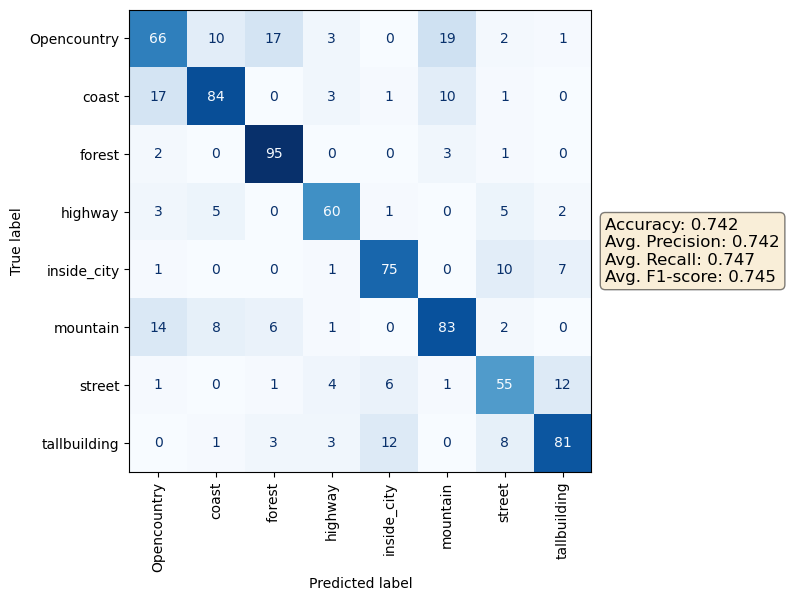

In [13]:
# plot confusion matrix

cm = confusion_matrix(bovw.test_dataset['labels'], predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(bovw.test_dataset['labels']))
_, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical', colorbar=False)

# Adding text for metrics
textstr = '\n'.join((
    f'Accuracy: {accuracy(predictions, bovw.test_dataset["labels"]):.3f}',
    f'Avg. Precision: {average_precision(predictions, bovw.test_dataset["labels"]):.3f}',
    f'Avg. Recall: {average_recall(predictions, bovw.test_dataset["labels"]):.3f}',
    f'Avg. F1-score: {average_f1(predictions, bovw.test_dataset["labels"]):.3f}'))

# These are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# Place a text box in upper left in axes coords
ax.text(1.03, 0.55, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.show()

#### 3.2.1 Micro averaged precision-recall curve
The micro averages precision recall curve allows us to analyze the precision-recall performance of each class and the average. We use the precision recall-curve instead of the ROC because the dataset is imbalanced and the ROC curve may be harder to analyze correctly in this case. Though, in the next chunck we also show the ROC curve.

For this example, classes 6 and 7 significanlty underperform the others.

Text(0.5, 1.0, 'Micro-averaged Precision-Recall curve')

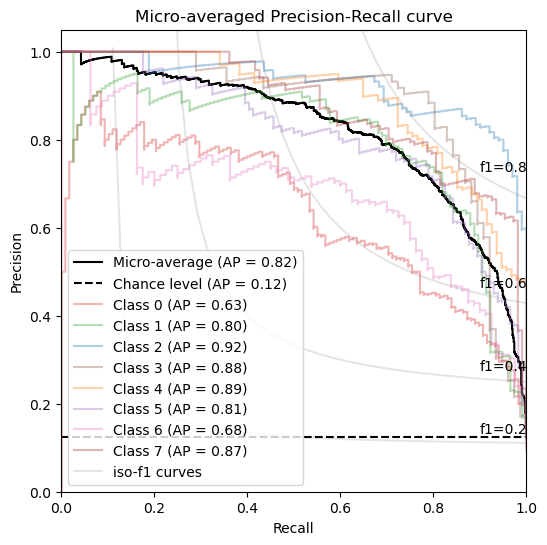

In [11]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

colors = ["tab:red", "tab:green", "tab:blue", "tab:brown", "tab:orange", "tab:purple", "tab:pink", "brown"]

y_onehot_test = LabelBinarizer().fit_transform(bovw.test_dataset['labels'])
n_classes = y_onehot_test.shape[1]

# For each class
precision_dict  = dict()
recall_dict  = dict()
average_precision_dict = dict()
for i in range(n_classes):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_onehot_test[:, i], y_score[:, i])
    average_precision_dict[i] = average_precision_score(y_onehot_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision_dict["micro"], recall_dict["micro"], _ = precision_recall_curve(
    y_onehot_test.ravel(), y_score.ravel()
)
average_precision_dict["micro"] = average_precision_score(y_onehot_test, y_score, average="micro")

_, ax = plt.subplots(figsize=(6, 6))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall_dict["micro"],
    precision=precision_dict["micro"],
    average_precision=average_precision_dict["micro"],
    prevalence_pos_label=Counter(y_onehot_test.ravel())[1] / y_onehot_test.size,
)
display.plot(ax=ax, name="Micro-average", plot_chance_level=True, color='black')

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall_dict[i],
        precision=precision_dict[i],
        average_precision=average_precision_dict[i],
    )
    display.plot(ax=ax, name=f"Class {i}", color=color, alpha=0.35)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Micro-averaged Precision-Recall curve")

In [ ]:
y_onehot_test = LabelBinarizer().fit_transform(bovw.test_dataset['labels'])
n_classes = y_onehot_test.shape[1]
fpr1, tpr1 = compute_micro_roc_curve(y_onehot_test, y_score)

plt.figure(figsize=(6, 6))
plt.plot(
    fpr1,
    tpr1,
    label=f"micro-average ROC curve (AUC = {auc(fpr1, tpr1):.2f})",
    color="tab:blue",
    linestyle=":",
    linewidth=4,
)

# plot chance level
plt.plot([0, 1], [0, 1], linestyle="--", color="black", linewidth=2, label="Chance")

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged ROC curve")
plt.legend()

#### 3.2.3 Accuracy over number of words
To understand if the amount of visual words has an impact on the accuracy, we do a bar plot. In this example, and generally, we can see that there is not an apparent relation.

C:\Users\Luis\AppData\Local\Temp\ipykernel_21532\2018220519.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.index, rotation=45, ha='right')


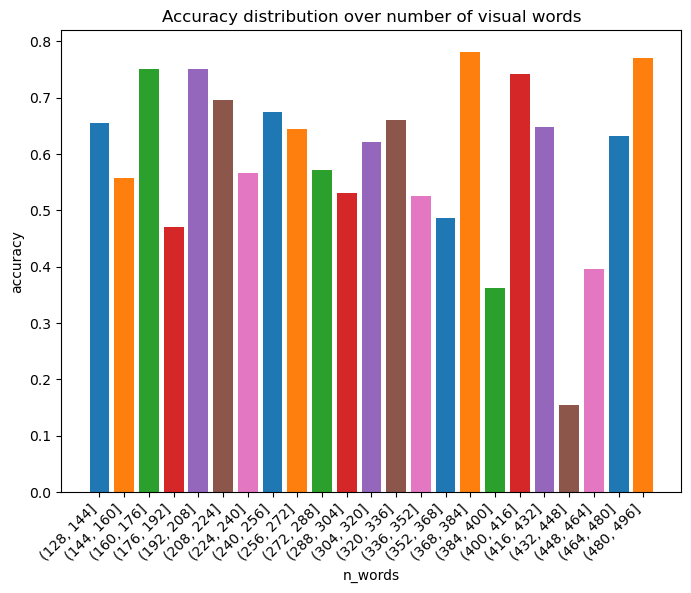

In [74]:

colors = [
    "#1f77b4",  # Muted blue
    "#ff7f0e",  # Safety orange
    "#2ca02c",  # Cooked asparagus green
    "#d62728",  # Brick red
    "#9467bd",  # Muted purple
    "#8c564b",  # Chestnut brown
    "#e377c2",  # Raspberry yogurt pink
]

df = pd.read_csv('wandb_export_2023-12-30T12_36_57.300+01_00.csv')[['Name', 'n_words', 'accuracy']]
df = df[df['n_words'] <= 512].groupby(pd.cut(df['n_words'], range(128, 513, 16))).mean().drop(columns=['n_words'])

# Convert interval index to string for plotting
df.index = df.index.astype(str)

# Plotting each bar with a different color
fig, ax = plt.subplots(figsize=(8, 6))

for i, (index, row) in enumerate(df.iterrows()):
    ax.bar(index, row['accuracy'], color=colors[i % len(colors)])

ax.set_xlabel('n_words')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy distribution over number of visual words')
ax.set_xticklabels(df.index, rotation=45, ha='right')
plt.show()

#### 3.2.4 Accuracy by number of visual words and PCA components
To understand if there is a relation between the amount of visual words and the amount of PCA components and the accuracy, we do the following 2D plot. The idea was to be able to see if for a given region of the plot, we would see an increase of accruacy. Nonetheless, this is not the case and for this example we can't observe any cluster of higher accuracy so we can't say there is a relation between the number of visual words, PCA components and accuracy.

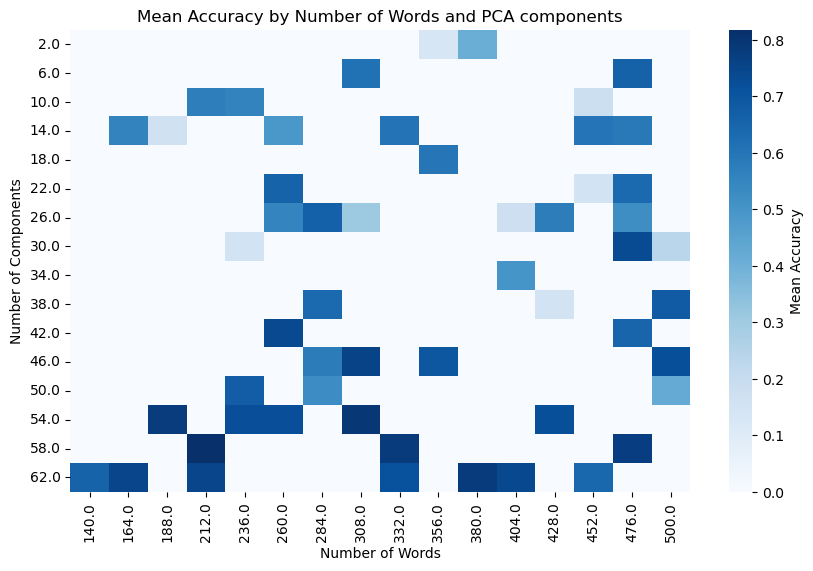

In [194]:

df = pd.read_csv('wandb_export_2023-12-30T12_36_57.300+01_00.csv')[['Name', 'n_words', 'accuracy', 'n_components']]
df['n_words_bin'] = pd.cut(df['n_words'], range(128, 513, 24))
df['n_components_bin'] = pd.cut(df['n_components'], range(0, 65, 4))

# Grouping by 'n_components_bin' and 'n_words_bin' and calculating mean
grouped_df = df.groupby(['n_components_bin', 'n_words_bin']).mean().drop(columns=['n_words', 'n_components'])

# Extracting the mid points of the bins for plotting
grouped_df.reset_index(inplace=True)
grouped_df['n_words_mid'] = grouped_df['n_words_bin'].apply(lambda x: x.mid)
grouped_df['n_components_mid'] = grouped_df['n_components_bin'].apply(lambda x: x.mid)

pivot_df = grouped_df.pivot("n_components_mid", "n_words_mid", "accuracy")
pivot_df_filled = pivot_df.fillna(0)

# Plotting the heatmap with NaN or 0 values distinctly colored
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df_filled, annot=False, cmap="Blues", cbar_kws={'label': 'Mean Accuracy'})
plt.title('Mean Accuracy by Number of Words and PCA components')
plt.xlabel('Number of Words')
plt.ylabel('Number of Components')
plt.show()

#### 3.2.5 Precison-Recall curve varying only 1 parameter
To futher experiment with the model, we plot the precision-recall curve only variying 1 parameter. First we vary the C value and then the kernel (for the SVM classificator). This way we can see if these variations produce any impact on the results.

In [44]:
# comparation of models changing only one parameter

config = {
    'descriptor': 'dense_sift',
    'step_size': 4,
    'n_words': 223,
    "n_features": 1024,
    'n_neigh': None,
    'metric': None,
    'n_folds': None,
    'n_components': 59,
    'level_pyramid': 1,
    'C':0.01,
    'degree_pol': 1,
    'kernel': None,
    'classifier': 'logistic',
    'fisher': False,
    'scaler': True,
}

all_predictions, all_y_scores = [], []
# kernel_values = ['precomputed', 'rbf', 'linear', 'poly']
c_values = [0.001, 0.01, 0.1, 1, 10, 100]
for x in c_values:
    config['C'] = x
    bovw = BoVW(config, preload_features=True)
    bovw.fit()
    predictions, y_score = bovw.predict()
    all_predictions.append(predictions)
    all_y_scores.append(y_score)

Text(0.5, 1.0, 'Micro-averaged Precision-Recall curve comparing different C values')

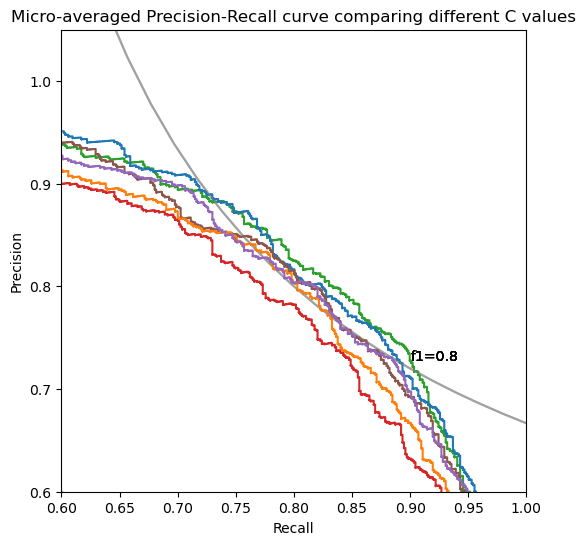

In [49]:
colors = ["tab:red", "tab:green", "tab:blue", "tab:brown", "tab:orange", "tab:purple", "tab:pink", "brown"]

y_onehot_test = LabelBinarizer().fit_transform(bovw.test_dataset['labels'])
n_classes = y_onehot_test.shape[1]

_, ax = plt.subplots(figsize=(6, 6))

for j, (predictions, y_score) in enumerate(zip(all_predictions, all_y_scores)):
    # For each class
    precision_dict  = dict()
    recall_dict  = dict()
    average_precision_dict = dict()
    for i in range(n_classes):
        precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_onehot_test[:, i], y_score[:, i])
        average_precision_dict[i] = average_precision_score(y_onehot_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision_dict["micro"], recall_dict["micro"], _ = precision_recall_curve(
        y_onehot_test.ravel(), y_score.ravel()
    )
    average_precision_dict["micro"] = average_precision_score(y_onehot_test, y_score, average="micro")

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall_dict["micro"],
        precision=precision_dict["micro"],
        average_precision=average_precision_dict["micro"],
        prevalence_pos_label=Counter(y_onehot_test.ravel())[1] / y_onehot_test.size,
    )
    display.plot(ax=ax, name=f"Micro-average for C={c_values[j]}", plot_chance_level=True if j == len(all_predictions)-1 else False, color=colors[j])


# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.6, 1.0])
ax.set_ylim([0.6, 1.05])
# ax.legend(handles=handles, labels=labels, loc="best")
# disable legend if you want to make a zoom
ax.legend_.remove()
ax.set_title("Micro-averaged Precision-Recall curve comparing different C values")

#### 3.2.6 Histogram of feature importance with and without regularization. 
For the logistic regression, we can use L2 regularization, it plays a crucial role in controlling the significance of different features. This control allows prioritizing certain features essential for accurate predictions.

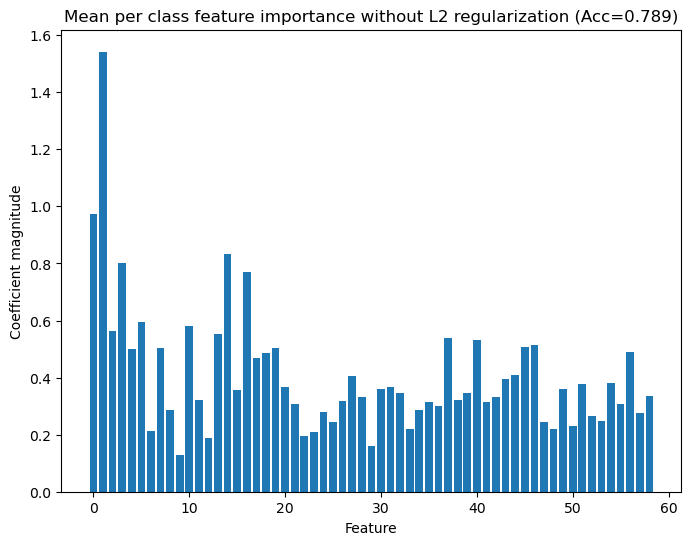

In [70]:
coef = abs(bovw.classifier.coef_)
coef = coef.mean(axis=0)

# plot bar chart with the coefficients
plt.figure(figsize=(8, 6))
plt.bar(np.arange(len(coef)), coef)
plt.xlabel('Feature')
plt.ylabel('Coefficient magnitude')
plt.title('Mean per class feature importance without L2 regularization (Acc=0.789)')
plt.show()

## 4. Conclusions

After performing all tests proposed for this lab and executing several combinations of hyperparameters and analyzing them with the previously proposed plots and the ones provided by wandb.ai (all of them are in the submitted PowerPoint), we can answer the following questions or proposals:

1. **Test different amounts of local features. What performs best? 

    Testing different quantities of local features per image depends on each method used.
        
    For AKAZE, the quantity is predefined, so we haven't tried different visual words.
    
    In the case of SIFT, the number of local features is crucial in determining the quantity of interesting local points needed to represent the image. For instance, setting it to 1024 means that the SIFT algorithm has to find 1024 points of interest. Experimenting with these values has helped us extract information in areas where finding points of interest is challenging, such as the sky and water.

    Regarding Dense SIFT, varying the number of local points implies how many pixels are sampled for specific points of interest in that area. Typically (and observed empirically), making each pixel a point of interest and later filtering has resulted in better outcomes. However, practically performing Dense SIFT per pixel has proven computationally impossible. Therefore, the minimum shift we could achieve was 10 pixels. This has allowed us to avoid losing information, as may happen with SIFT (e.g., in the sky and sea), yielding the best results.

    However, it's important to note that we have only worked with local information, without considering color—solely focusing on geometry.

2. **Use dense SIFT instead of detected keypoints. Conclusions?**  
   We can affirm dense-SIFT is the KP descriptor that performs the best. Between SIFT and AKAZE, we can’t conclude one performs better than the other. Moreover, the best step_size for the best combination of hyperparameters is 4 (generally it is a low value), though we can't condlude there is a best step_size for all models.

3. **Does a norm or scaler help?**  
   We can’t say that using scaling improves the results, since when using it or not the performance is not significantly different.

4. **Test different amounts of codebook sizes k. What performs best?**  
   We can’t conclude there is a tendency that relates accuracy and codebook size. Though, for the best combination, the optimal codebook size was 233.

5. **Test different values of k for the k-nn classifier. What performs best?**  
   Results show similarity across the different scenarios, with the best balance at 9 neighbors. Though, at 1 neighbor, the results show poorer performance.

6. **Test other distances in k-nn classifier. Does that make a difference?**  
   The metric indicates a lack of compelling evidence to assert the superiority of one distance measure over the others. Theoretically, this seems perplexing, especially considering that the cosine distance might not intuitively align with the context. However, empirically, the results closely resemble those obtained with the Euclidean and Manhattan distances which seems more convenient.

7. **Test on SVM classifier: Linear, RBF and histogram intersection kernels.**  
   The precision-recall curve is very similar for all the kernels, except for the RBF kernel. We can clearly see that it underperforms all the others notoriously. For the histogram intersection, linear and polynomial kernels, their performance can’t be considered significantly different.

8. **Play with reducing dimensionality:**  
   It seems that there is a tendency that relates the amount of PCA components and the accuracy. The more PCA components we keep, the better the system performs. Though, this increase seems to be logarithmic.

9. **Cross-validate everything.**  
   All the shown results are cross-validated with 5 folds, to ensure robustness in the results.

10. **Spatial Pyramids**  
    We can't conclude there is a best value for the pyramid. It would seem that 1 is the best value, but due to variance we can't affirm it.

11. **Fisher Vectors:**  
    The use of Fisher Vectors generally worsens the accuracy and F1. Nonetheless, there is some variation of the accuracy and F1 when using them, so we can’t conclude it is better to use them.

*There is further explanation and justification in the PowerPoint. Moreover, we added an interpretability section.*
